Instead of UnivariateMultistep_LSTM_forecast which output a vector sequence directly, We implement Univariate EncoderDecoder_LSTM that comprised of two sub models, the encoder to read and encode the input sequence, and the decoder will read the encoded input sequence and make a one-step prediction for each element in the output sequence.

In [1]:
# univariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
import numpy as np

import pandas as pd
from sklearn.metrics import mean_squared_error 

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed

Using TensorFlow backend.
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tridoan/opt/anaconda3/lib/pytho

In [ ]:
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
    train, test = data[1:-328], data[-328:-6] 
    # restructure into windows of weekly data

    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted): 
    scores = list()
    # calculate an RMSE score for each day 
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
  # calculate overall RMSE

    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))
    
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) 
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance 
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1)) 
            X.append(x_input) 
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

 

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted): 
    scores = list()
    # calculate an RMSE score for each day 
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
          # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1])) 
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))
    
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) 
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance 
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
    in_start += 1
    return np.array(X), np.array(y)

we define an LSTM hidden layer with 200 units. This is the encoder model that will read the input sequence and will output a 200 element vector (one output per unit) that captures features from the input sequence. We will use 14 days of total power consumption as input.    

First, the internal representation of the input sequence is repeated multiple times, once for each time step in the output sequence. This sequence of vectors will be presented to the LSTM decoder.   
We use LSTM hidden layer with 200 units. Importantly, the decoder will output the entire sequence, not just the output at the end of the sequence as we did with the encoder. This means that each of the 200 units will output a value for each of the seven days, representing the basis for what to predict for each day in the output sequence.

In [ ]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
   
      # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
      # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True)) 
    model.add(TimeDistributed(Dense(100, activation='relu'))) 
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose) 
    return model

We use a fully connected layer to interpret each time step in the output sequence before the final output layer. Importantly, the output layer predicts a single step in the output sequence, not all seven days at a time.   

This means that we will use the same layers applied to each step in the output sequence. It means that the same fully connected layer and output layer will be used to process each time step provided by the decoder.   

To achieve this, we will wrap the interpretation layer and the output layer in a TimeDistributed wrapper that allows the wrapped layers to be used for each time step from the decoder.  

This allows the LSTM decoder to figure out the context required for each step in the output sequence and the wrapped dense layers to interpret each time step separately, yet reusing the same weights to perform the interpretation. An alternative would be to flatten all of the structure created by the LSTM decoder and to output the vector directly.

In [6]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1)) # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input): 
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data 
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
            # store the predictions
        predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next week
        history.append(test[i, :])
      # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
    return score, scores

In [ ]:
# load the new file
dataset = pd.read_csv('./Downloads/data/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)

There is a single feature, the daily total power consumed, and there are always seven features.
A single one-week prediction will therefore have the size: [1, 7, 1]. Therefore, when training the model, we must restructure the output data (y) to have the three-dimensional structure instead of the two-dimensional structure of [samples, features] 

lstm: [673.985] 458.7, 520.2, 754.0, 832.2, 554.6, 596.6, 879.9


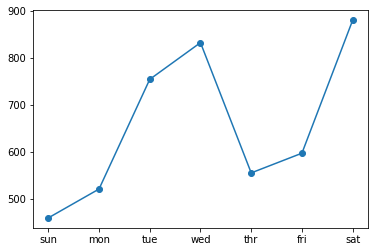

In [7]:
# evaluate model and get scores
n_input = 14


score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
plt.plot(days, scores, marker='o', label='lstm')
plt.show()